**Index**:
- [Data loading](#Data-loading)
- [Individual models](#Individual-models)
    - [ANN](#ANN)
    - [ScikitLearn ANN](#ScikitLearn-ANN)
    - [Decision Tree](#Decision-Tree)
    - [Support Vector Machine](#Support-Vector-Machine)
- [Base results analysis](#Base-results-analysis) 
- [Ensemble models](#Ensemble-models)
- [Evaluation of the best ensemble](#Evaluation-of-the-best-ensemble)

# First approach: no preprocessing

In this first approach, we will not preprocess the data and we will use all the features available. We are going to train 4 different models with the following hyperparameters:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble models](#Ensemble-models)


## Data loading

In this approach, we will not preprocess the data and all the models will be trained with the raw data. To evaluate the models, we will use a **5-fold cross-validation** instead of splitting the data into training and test sets. By doing this, we will be able to compare the models in a more robust way and reduce the dependence on the randomness of the data split.

Regarding to the metrics used to evaluate the models, we will use the **accuracy**, **precision**, **recall** and **f1-score**. The reason to not use only the accuracy is that the dataset is unbalanced and the accuracy can be misleading.

We will start by loading the data, splitting it into training and test sets and defining the cross-validation strategy.


In [6]:
using DataFrames
using CSV
using Serialization

In [7]:
# Load custom functions from provided files
include("utils/preprocessing.jl")
include("utils/metrics.jl")
include("utils/training.jl")
include("utils/plotting.jl")

showConfusionMatrix (generic function with 1 method)

In [8]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "datasets/dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

5×35 DataFrame
 Row │ Marital status  Application mode  Application order  Course  Daytime/ev ⋯
     │ Int64           Int64             Int64              Int64   Int64      ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │              1                 8                  5       2             ⋯
   2 │              1                 6                  1      11
   3 │              1                 1                  5       5
   4 │              1                 8                  2      15
   5 │              2                12                  1       3             ⋯
                                                              31 columns omitted

In [9]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [10]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


In [11]:
# Split into training and testing sets
Random.seed!(42)
train_indices, test_indices = holdOut(inputs, targets, 0.15)
test_inputs = inputs[test_indices, :]
test_targets = targets[test_indices]
inputs = inputs[train_indices, :]
targets = targets[train_indices];

In [7]:
function count_classes(targets::AbstractArray{<:Any,1})
    counts = Dict{Any, Int}()
    for target in targets
        counts[target] = get(counts, target, 0) + 1
    end
    return counts
end

# Ensure the frequency of each class is similar in the training and testing sets
count_train = count_classes(targets)
println("Training set distribution: ")
for (label, count) in count_train
    println("Label: ", label, ", Frequency ratio: ", count / length(targets))
end

count_test = count_classes(test_targets)
println("Testing set distribution: ")
for (label, count) in count_test
    println("Label: ", label, ", Frequency ratio: ", count / length(test_targets))
end

Training set distribution: 
Label: Enrolled, Frequency ratio: 0.17819148936170212
Label: Graduate, Frequency ratio: 0.5066489361702128
Label: Dropout, Frequency ratio: 0.3151595744680851
Testing set distribution: 
Label: Enrolled, Frequency ratio: 0.18674698795180722
Label: Graduate, Frequency ratio: 0.4578313253012048
Label: Dropout, Frequency ratio: 0.35542168674698793


In [8]:
# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## Individual models


### ANN

We are going to use the our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 5 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [12]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.83902 ± 0.00562
	Class 1: 0.86427 ± 0.01013
	Class 2: 0.8285 ± 0.00841
	Class 3: 0.8231 ± 0.00236
Mean precision: 0.73893 ± 0.00568
	Class 1: 0.80192 ± 0.02562
	Class 2: 0.77941 ± 0.01239
	Class 3: 0.51359 ± 0.01243
Mean recall: 0.75794 ± 0.00721
	Class 1: 0.7686 ± 0.03371
	Class 2: 0.9163 ± 0.01525
	Class 3: 0.29825 ± 0.01302
Mean f1_score: 0.74 ± 0.00619
	Class 1: 0.78423 ± 0.01734
	Class 2: 0.84217 ± 0.00711
	Class 3: 0.37658 ± 0.00848
Training ANN with topology: [32]
Mean accuracy: 0.84332 ± 0.00451
	Class 1: 0.8666 ± 0.00896
	Class 2: 0.83487 ± 0.00802
	Class 3: 0.82516 ± 0.00279
Mean precision: 0.74568 ± 0.00489
	Class 1: 0.81076 ± 0.01966
	Class 2: 0.78435 ± 0.01271
	Class 3: 0.52166 ± 0.01261
Mean recall: 0.76331 ± 0.00549
	Class 1: 0.76361 ± 0.02847
	Class 2: 0.92359 ± 0.00716
	Class 3: 0.31686 ± 0.01798
Mean f1_score: 0.74668 ± 0.00603
	Class 1: 0.78604 ± 0.01589
	Class 2: 0.8482 ± 0.00583
	Class 3: 0.39382 ± 0.01424
Training 

### ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [14]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.84153 ± 0.00524
	Class 1: 0.84445 ± 0.01402
	Class 2: 0.84876 ± 0.01184
	Class 3: 0.82536 ± 0.00777
Mean precision: 0.74403 ± 0.00509
	Class 1: 0.78437 ± 0.00906
	Class 2: 0.7816 ± 0.04118
	Class 3: 0.53383 ± 0.04896
Mean recall: 0.75929 ± 0.00689
	Class 1: 0.85351 ± 0.0681
	Class 2: 0.7711 ± 0.061
	Class 3: 0.38368 ± 0.06635
Mean f1_score: 0.7456 ± 0.00659
	Class 1: 0.81525 ± 0.03159
	Class 2: 0.77202 ± 0.03193
	Class 3: 0.44275 ± 0.05858
Training ANN with topology: [32]
Mean accuracy: 0.84296 ± 0.00548
	Class 1: 0.84658 ± 0.01489
	Class 2: 0.85093 ± 0.00962
	Class 3: 0.82527 ± 0.00682
Mean precision: 0.74658 ± 0.00689
	Class 1: 0.7957 ± 0.01555
	Class 2: 0.7828 ± 0.03477
	Class 3: 0.53206 ± 0.04087
Mean recall: 0.76139 ± 0.00734
	Class 1: 0.86238 ± 0.05408
	Class 2: 0.7717 ± 0.06204
	Class 3: 0.38219 ± 0.06837
Mean f1_score: 0.74772 ± 0.00825
	Class 1: 0.82562 ± 0.01756
	Class 2: 0.77231 ± 0.03313
	Class 3: 0.44018 ± 0.05821
Training 

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [15]:
max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.82098 ± 0.00787
	Class 1: 0.81803 ± 0.02407
	Class 2: 0.82889 ± 0.02407
	Class 3: 0.81554 ± 0.02844
Mean precision: 0.73083 ± 0.01257
	Class 1: 0.77224 ± 0.03368
	Class 2: 0.74476 ± 0.16579
	Class 3: 0.53349 ± 0.18216
Mean recall: 0.73124 ± 0.0101
	Class 1: 0.86233 ± 0.08844
	Class 2: 0.65608 ± 0.13301
	Class 3: 0.44091 ± 0.15518
Mean f1_score: 0.72405 ± 0.01272
	Class 1: 0.81145 ± 0.03138
	Class 2: 0.69373 ± 0.13476
	Class 3: 0.47729 ± 0.16253
Training DT model with max_depth: 5
Mean accuracy: 0.83244 ± 0.00974
	Class 1: 0.816 ± 0.01603
	Class 2: 0.86099 ± 0.01035
	Class 3: 0.82708 ± 0.0034
Mean precision: 0.74013 ± 0.00879
	Class 1: 0.74679 ± 0.02117
	Class 2: 0.84335 ± 0.01507
	Class 3: 0.53688 ± 0.02204
Mean recall: 0.75203 ± 0.01061
	Class 1: 0.957 ± 0.00997
	Class 2: 0.69737 ± 0.04672
	Class 3: 0.27948 ± 0.07727
Mean f1_score: 0.72868 ± 0.01437
	Class 1: 0.83871 ± 0.01107
	Class 2: 0.76251 ± 0.02596
	Class 3: 0.36191 ± 0.06756


### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [16]:
kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.8432 ± 0.00893
	Class 1: 0.84605 ± 0.02892
	Class 2: 0.84563 ± 0.01951
	Class 3: 0.83589 ± 0.02283
Mean precision: 0.7525 ± 0.01004
	Class 1: 0.79412 ± 0.04257
	Class 2: 0.75589 ± 0.14902
	Class 3: 0.59217 ± 0.15534
Mean recall: 0.76378 ± 0.01203
	Class 1: 0.87024 ± 0.09831
	Class 2: 0.7198 ± 0.24033
	Class 3: 0.4202 ± 0.17341
Mean f1_score: 0.74907 ± 0.01304
	Class 1: 0.82585 ± 0.02532
	Class 2: 0.72933 ± 0.18427
	Class 3: 0.48925 ± 0.17013
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.84537 ± 0.00569
	Class 1: 0.83905 ± 0.01266
	Class 2: 0.85647 ± 0.02107
	Class 3: 0.83702 ± 0.02191
Mean precision: 0.7552 ± 0.00521
	Class 1: 0.78185 ± 0.01209
	Class 2: 0.77306 ± 0.14164
	Class 3: 0.59465 ± 0.14879
Mean recall: 0.76627 ± 0.00793
	Class 1: 0.89881 ± 0.081
	Class 2: 0.69364 ± 0.20171
	Class 3: 0.43747 ± 0.16641
Mean f1_score: 0.75322 ± 0.00783
	Class 1: 0.83438 ± 0.03274
	Class 2: 0.72668 ± 0.16694
	

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [17]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        verbose=false
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77367 ± 0.00779
	Class 1: 0.77372 ± 0.03536
	Class 2: 0.77692 ± 0.02355
	Class 3: 0.78074 ± 0.02212
Mean precision: 0.66309 ± 0.00824
	Class 1: 0.72083 ± 0.01574
	Class 2: 0.65791 ± 0.17208
	Class 3: 0.43654 ± 0.17793
Mean recall: 0.66569 ± 0.01155
	Class 1: 0.75429 ± 0.07426
	Class 2: 0.62255 ± 0.18571
	Class 3: 0.40546 ± 0.13893
Mean f1_score: 0.66249 ± 0.01058
	Class 1: 0.73597 ± 0.04082
	Class 2: 0.63784 ± 0.1743
	Class 3: 0.41969 ± 0.15616
Training KNN model with n_neighbors: 3
Mean accuracy: 0.79097 ± 0.00823
	Class 1: 0.77892 ± 0.01499
	Class 2: 0.80381 ± 0.01846
	Class 3: 0.80334 ± 0.01437
Mean precision: 0.6703 ± 0.01291
	Class 1: 0.72511 ± 0.02501
	Class 2: 0.6661 ± 0.12383
	Class 3: 0.46502 ± 0.15686
Mean recall: 0.69304 ± 0.01206
	Class 1: 0.82444 ± 0.07129
	Class 2: 0.63887 ± 0.21364
	Class 3: 0.33358 ± 0.20866
Mean f1_score: 0.67583 ± 0.01245
	Class 1: 0.77099 ± 0.04435
	Class 2: 0.64746 ± 0.17582
	Class 3: 0.38343 ±

### Save the results

In order to be able to compare the results of the models without running the training again, we will save the results in a dictionary. The dictionary will have the following structure:

```julia
{
    :model: {
        'num_trained_models': int,
        'parameters': Dict{String, Any},
        'general_results': [
            {
                'accuracy': AbstractVector{Float64},
                'precision': AbstractVector{Float64},
                'recall': AbstractVector{Float64},
                'f1_score': AbstractVector{Float64},
            },
            ... # One element for each trained model
        ],
        'class_results': [
            [
                {
                    'accuracy': AbstractVector{Float64},
                    'precision': AbstractVector{Float64},
                    'recall': AbstractVector{Float64},
                    'f1_score': AbstractVector{Float64},
                },
                ... # One element for each class
            ],
            ... # One element for each trained model
        ]
    }
}
```

The results of all approaches will be avaiable in the `results` dictionary. The filename with the results of individual models of this first approach will be `1_individual_results.jl`.


In [20]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "1_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [9]:
results_folder = "results/"
filename = results_folder * "1_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

# As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 6

Model 1: max_depth: 3, 
Mean recall: 0.73124 ± 0.0101
	Class 1: 0.86233
	Class 2: 0.65608
	Class 3: 0.44091
Mean f1_score: 0.72405 ± 0.01272
	Class 1: 0.81145
	Class 2: 0.69373
	Class 3: 0.47729
Mean precision: 0.73083 ± 0.01257
	Class 1: 0.77224
	Class 2: 0.74476
	Class 3: 0.53349
Mean accuracy: 0.82098 ± 0.00787
	Class 1: 0.81803
	Class 2: 0.82889
	Class 3: 0.81554

Model 2: max_depth: 5, 
Mean recall: 0.75203 ± 0.01061
	Class 1: 0.957
	Class 2: 0.69737
	Class 3: 0.27948
Mean f1_score: 0.72868 ± 0.01437
	Class 1: 0.83871
	Class 2: 0.76251
	Class 3: 0.36191
Mean precision: 0.74013 ± 0.00879
	Class 1: 0.74679
	Class 2: 0.84335
	Class 3: 0.53688
Mean accuracy: 0.83244 ± 0.00974
	Class 1: 0.816
	Class 2: 0.86099
	Class 3: 0.82708

Model 3: max_depth: 10, 
Mean recall: 0.72445 ± 0.01218
	Class 1: 0.82611
	Class 2: 0.74263
	Class 3: 0.37527
Mean f1_score: 0.7181 ± 0.01354
	Class 1: 0.80662
	Class 2: 0.74717
	Class 3: 0.40395
Mean precision: 0.7162

## Base results analysis

In [10]:
# Aggregate metrics
model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)
plots_output_dir = "./plots/Approach1/"
tables_output_dir = "./tables/Approach1/"

"./tables/Approach1/"

In [11]:
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, output_dir=plots_output_dir)

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [12]:
# Plot metrics for each class
plotMetricsAlgorithm(loaded_obj, 3, output_dir=plots_output_dir)

Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Class 2.
Saved plots for DT and f1_score on Class 2.
Saved plots for DT and accuracy on Class 3.
Saved plots for DT and precision on Class 3.
Saved plots for DT and recall on Class 3.
Saved plots for DT and f1_score on Class 3.
Saved plots for KNN and accuracy on Class 1.
Saved plots for KNN and precision on Class 1.
Saved plots for KNN and recall on Class 1.
Saved plots for KNN and f1_score on Class 1.
Saved plots for KNN and accuracy on Class 2.
Saved plots for KNN and precision on Class 2.
Saved plots for KNN and recall on Class 2.
Saved plots for KNN and f1_score on Class 2.
Saved plots for KNN and accuracy on Class 3.
Saved plots for KNN and precision on Class 3.
Saved plots for KNN and re

In [13]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.832439 │  0.740135 │ 0.752031 │  0.72868 │
│       max_depth: 3 │ 0.820979 │  0.730834 │ 0.731235 │ 0.724049 │
│      max_depth: 10 │ 0.818095 │  0.716246 │ 0.724455 │ 0.718105 │
│      max_depth: 15 │  0.79861 │  0.691672 │  0.69552 │  0.69291 │
│ max_depth: nothing │ 0.787128 │  0.681112 │ 0.679923 │ 0.680156 │
│      max_depth: 20 │ 0.787096 │  0.680999 │ 0.679689 │ 0.680043 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach1/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

In [14]:
# Generate tables for each algorithm for each class sorted by f1 score
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, output_dir=tables_output_dir, rev=true)


Comparison of Hyperparameter Configurations for DT on Class 1 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.815997 │  0.746793 │    0.957 │ 0.838713 │
│       max_depth: 3 │ 0.818033 │  0.772236 │ 0.862326 │ 0.811448 │
│      max_depth: 10 │ 0.820287 │  0.790838 │ 0.826105 │ 0.806619 │
│      max_depth: 15 │ 0.800169 │  0.769327 │ 0.795721 │ 0.782052 │
│      max_depth: 20 │ 0.780273 │   0.78248 │ 0.776828 │ 0.779427 │
│ max_depth: nothing │ 0.781411 │  0.786996 │ 0.771395 │ 0.779008 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT on Class 1 saved to ./tables/Approach1/.

Comparison of Hyperparameter Configurations for DT on Class 2 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Acc

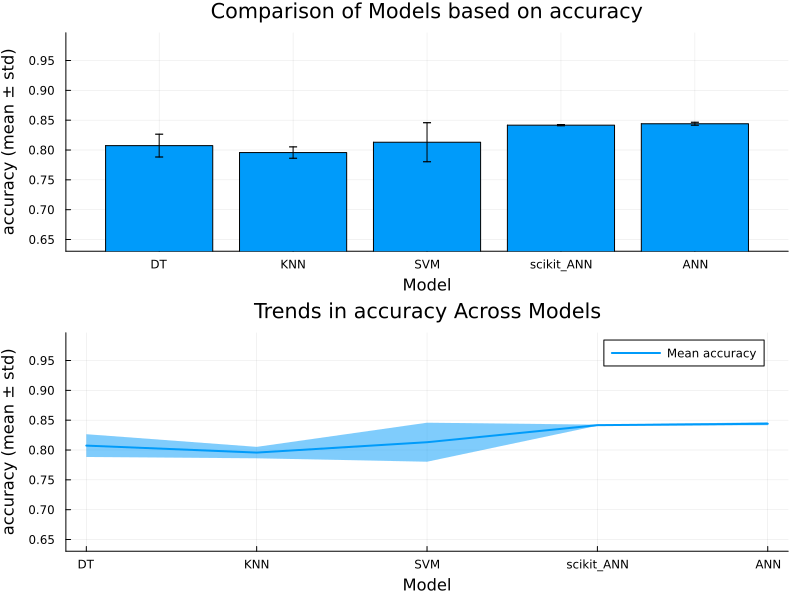

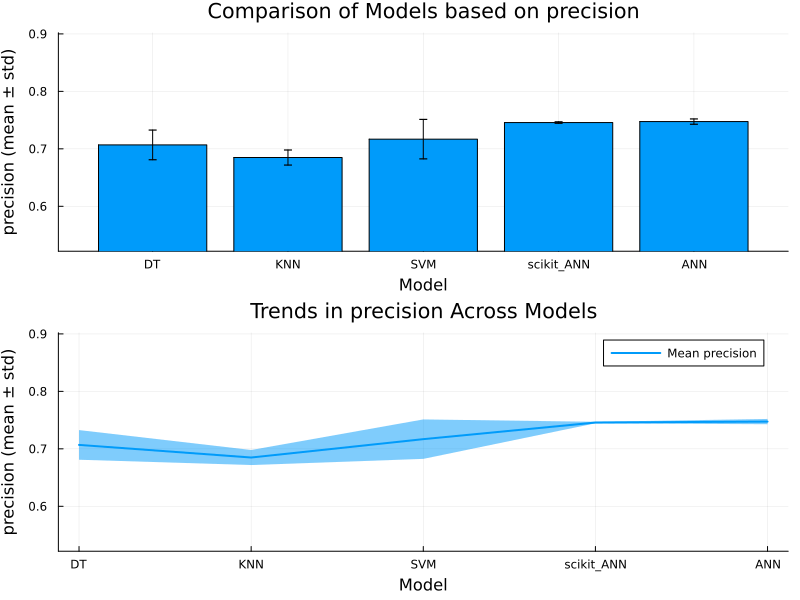

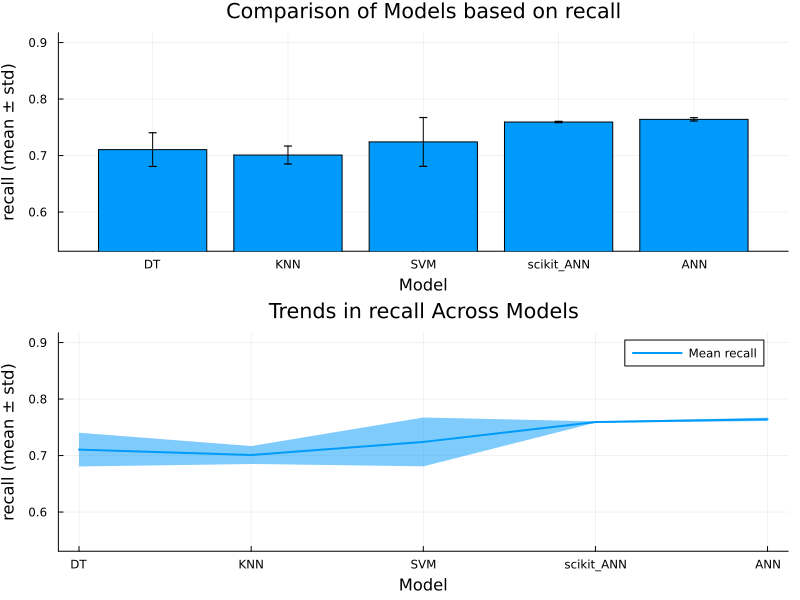

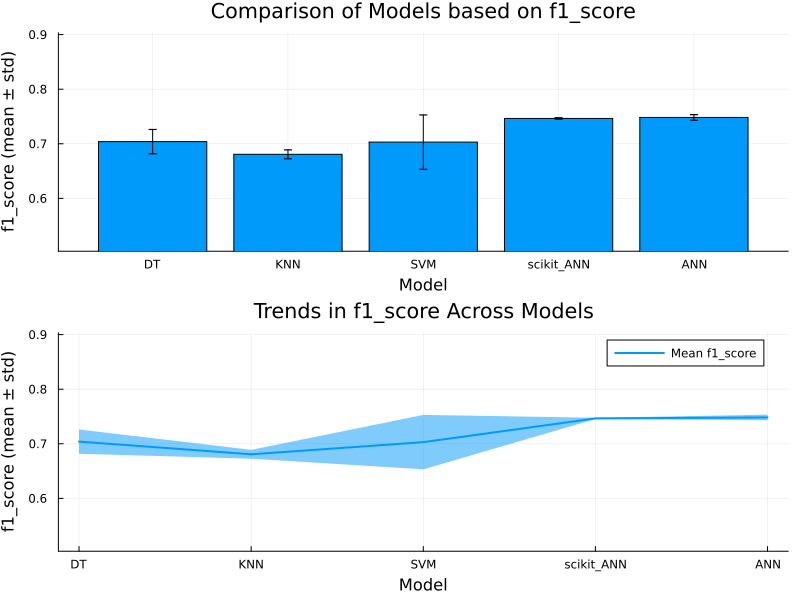

In [15]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

In [17]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=false)

In [18]:
# Generate and print the overall comparison table
generateComparisonTable(model_names, metrics, metric_maxes; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        ANN │    0.847 │     0.753 │  0.768 │    0.755 │
│        SVM │    0.845 │     0.756 │  0.766 │    0.754 │
│ scikit_ANN │    0.843 │     0.747 │  0.761 │    0.749 │
│         DT │    0.832 │      0.74 │  0.752 │    0.729 │
│        KNN │    0.802 │       0.7 │  0.713 │    0.687 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [19]:
# Generate and print the overall comparison table by class
generateComparisonTable(model_names, metrics, metric_maxes; output_dir=tables_output_dir, sort_by=:accuracy, rev=true)


Comparison of Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        ANN │    0.847 │     0.753 │  0.768 │    0.755 │
│        SVM │    0.845 │     0.756 │  0.766 │    0.754 │
│ scikit_ANN │    0.843 │     0.747 │  0.761 │    0.749 │
│         DT │    0.832 │      0.74 │  0.752 │    0.729 │
│        KNN │    0.802 │       0.7 │  0.713 │    0.687 │
└────────────┴──────────┴───────────┴────────┴──────────┘


On the one hand, the **Artificial Neural Network (ANN)** stands out as the best-performing model, with its `[64, 32]` topology achieving an accuracy of 84.7% and an F1-score of 75.5%. Large architectures like `[64, 64]` show diminishing returns, indicating the `[64, 32]` setup balances complexity and performance. 

On the other hand, the **K-Nearest-Neighbors** achieves the worst performance. With it's best configuration, `n_neighbors: 11`, it achieves an F1-score of $68,7\%$. In general, no tendency is observed in the performance of the model as the number of neighbors increases or decreases. All configurations show similar poor performance.

The **Support Vector Machine(SVM)**, with `C: 0.1, kernel: linear`, achieves an F1-score of $75,4\%$, similar to the one obtained with the ANN. The **Scikit Learn ANN** also presents analogous results to the ANN, but with a simpler topology. The best configuration, `hidden_layer_sizes: [64]`, achieves an F1-score of $74,9\%$.

The **Decision Tree (DT)** performs best with `max_depth: 5`, achieving 80.2% accuracy and a 72.9% F1-score. As depth increases, performance declines due to overfitting.

## Ensemble models

After training the individual models, we will train an ensemble model with the three best models (taking Scikit Learn ANN instead of ANN), taking each of the best configurations. This is:

- **Scikit-Learn ANN**: `[64]`
- **Support Vector Machine**: `C: 10, kernel: linear`
- **Decision Tree**: `max_depth: 5`


The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Stacking** (using a logistic regression as the meta-model)


In [ ]:
# Select the best models
estimators = [:ANN, :SVC, :DT]
hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (64, 32),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
    :kernel => "linear",
    :C => 10.0,
    :gamma => "auto",
    :probability => true,
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
)])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.4, 0.4, 0.2]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]

3-element Vector{Dict{Symbol, Any}}:
 Dict(:type => :Voting, :hyperparameters => Dict{Any, Any}())
 Dict(:type => :Voting, :hyperparameters => Dict{Symbol, Any}(:voting => "soft", :weights => [0.4, 0.4, 0.2]))
 Dict(:type => :Stacking, :hyperparameters => Dict{Symbol, PyCall.PyObject}(:final_estimator => PyObject LogisticRegression()))

In [26]:
for (index, ensemble) in enumerate(ensembles)
    println("Training ensemble ", ensemble[:type])
    metrics, class_results = trainClassEnsemble(
        estimators,
        hyperparameters,
        (inputs, targets),
        fold_indices;
        ensembleType=ensemble[:type],
        ensembleHyperParameters=ensemble[:hyperparameters],
        metricsToSave=metrics_to_save,
        verbose=false,
        repetitionsTraining=5
    )
    ensemble[:results] = metrics
    ensemble[:class_results] = class_results
    println("------------------------------------")
end

Training ensemble Voting
Mean accuracy: 0.84826 ± 0.00502
	Class 1: 0.85343 ± 0.02173
	Class 2: 0.85408 ± 0.01866
	Class 3: 0.83644 ± 0.01356
Mean precision: 0.75931 ± 0.00875
	Class 1: 0.80541 ± 0.03965
	Class 2: 0.78878 ± 0.05451
	Class 3: 0.58401 ± 0.08866
Mean recall: 0.77197 ± 0.00747
	Class 1: 0.86864 ± 0.10975
	Class 2: 0.76977 ± 0.17984
	Class 3: 0.39471 ± 0.12188
Mean f1_score: 0.75603 ± 0.00763
	Class 1: 0.83055 ± 0.03273
	Class 2: 0.77029 ± 0.11502
	Class 3: 0.46727 ± 0.11043
------------------------------------
Training ensemble Voting
Mean accuracy: 0.85062 ± 0.00683
	Class 1: 0.85542 ± 0.01758
	Class 2: 0.8525 ± 0.01976
	Class 3: 0.84137 ± 0.02156
Mean precision: 0.76175 ± 0.01278
	Class 1: 0.80309 ± 0.02566
	Class 2: 0.76416 ± 0.09187
	Class 3: 0.61352 ± 0.13552
Mean recall: 0.77464 ± 0.01025
	Class 1: 0.88103 ± 0.08776
	Class 2: 0.72157 ± 0.2012
	Class 3: 0.4468 ± 0.17927
Mean f1_score: 0.76005 ± 0.01099
	Class 1: 0.83675 ± 0.02929
	Class 2: 0.73335 ± 0.14812
	Class 3: 

In [27]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "1_ensemble_results.jl"

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :Voting_Hard => Dict(
    "general_results" => ensembles[1][:results],
    "class_results" => ensembles[1][:class_results]
  ),
  :Voting_Soft => Dict(
    "general_results" => ensembles[2][:results],
    "class_results" => ensembles[2][:class_results]
  ),
  :Stacking => Dict(
    "general_results" => ensembles[3][:results],
    "class_results" => ensembles[3][:class_results]
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

### Ensemble model plots


In [ ]:
filename = results_folder * "1_ensemble_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3, ensemble=true)
plots_output_dir = "./plots/Approach1/ensembles"
tables_output_dir = "./tables/Approach1/ensembles"

"./tables/Approach1/ensembles"

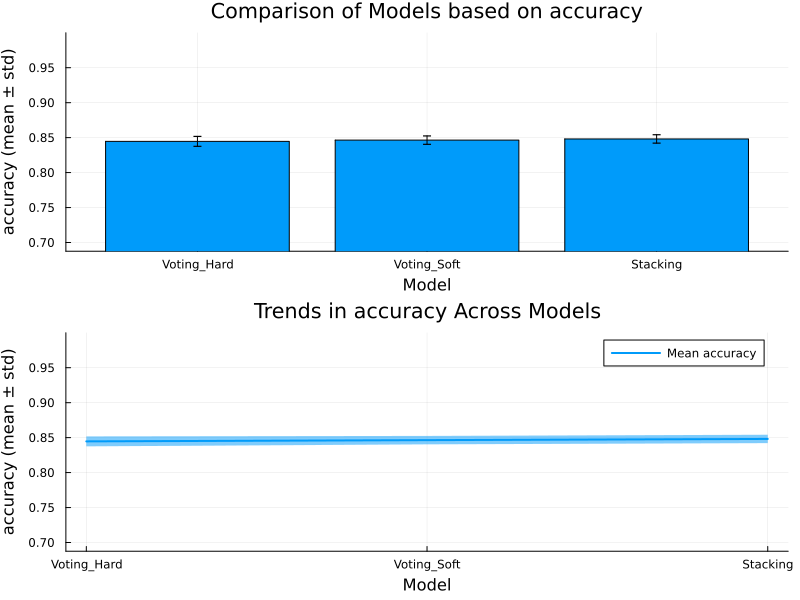

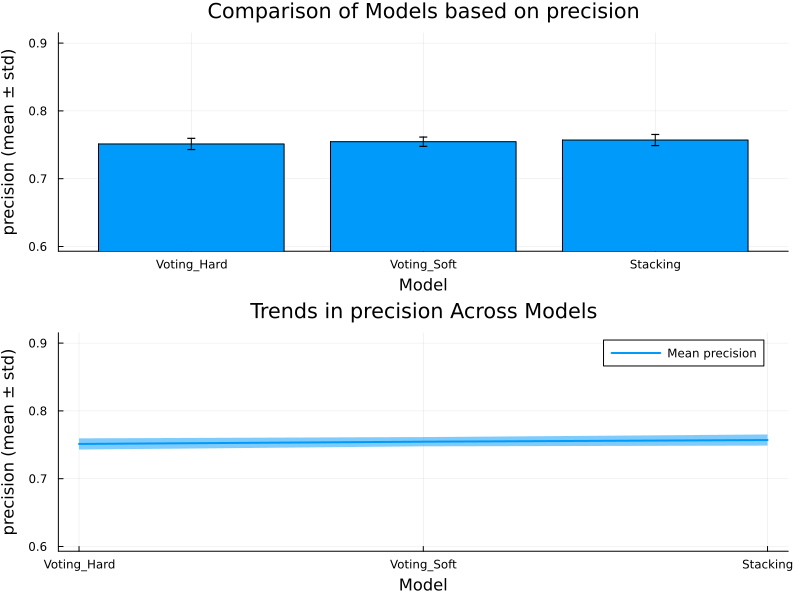

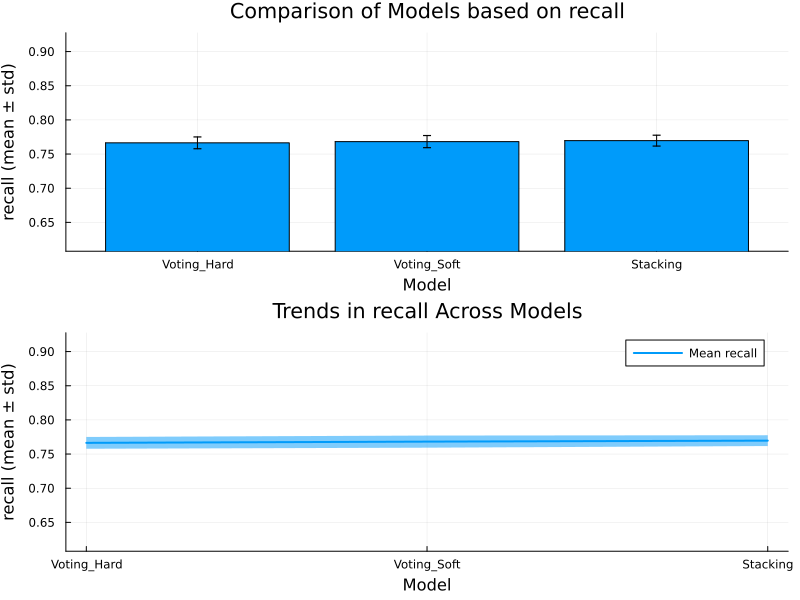

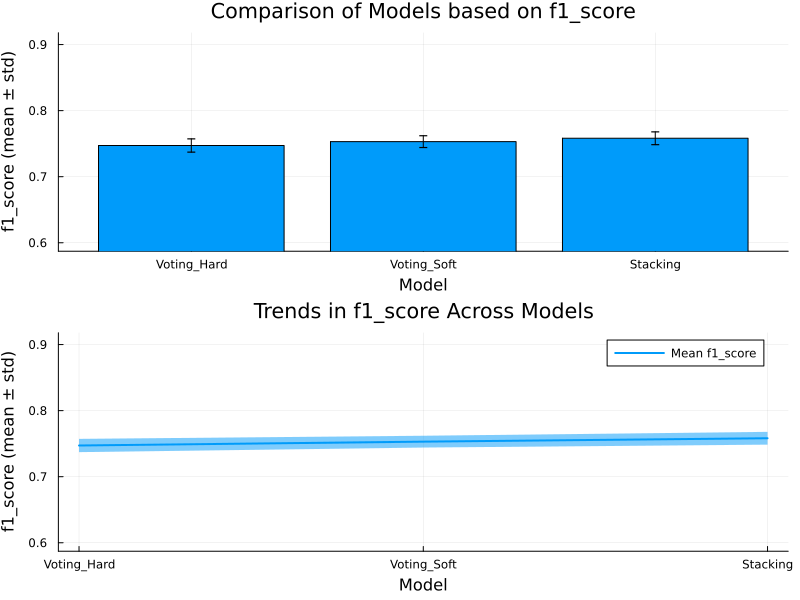

In [113]:
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir=plots_output_dir, show=true)

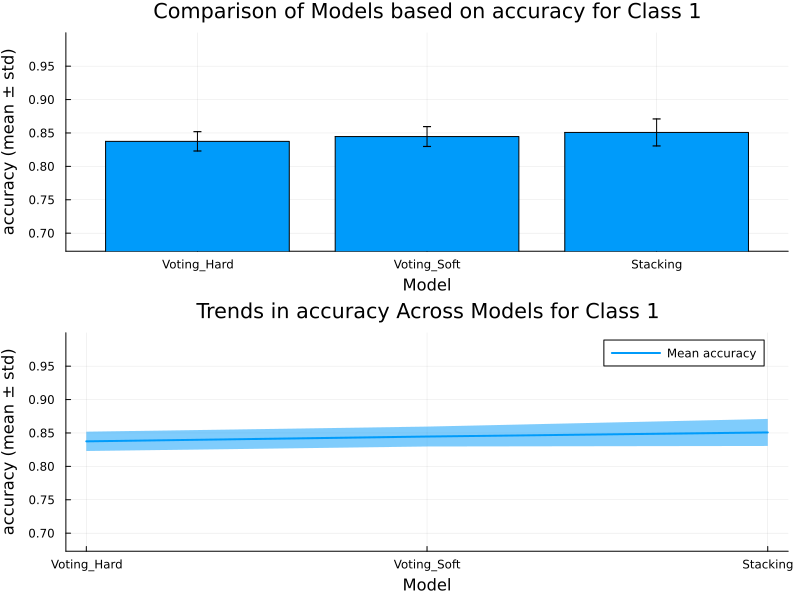

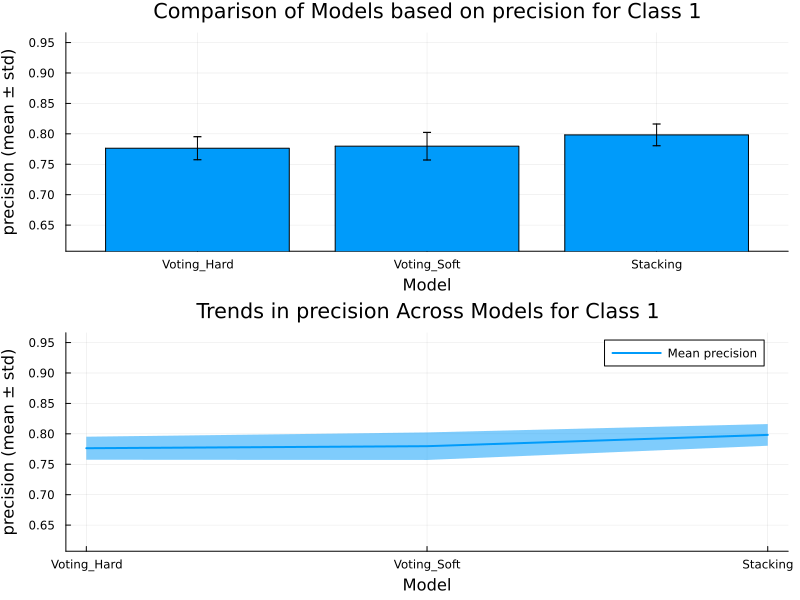

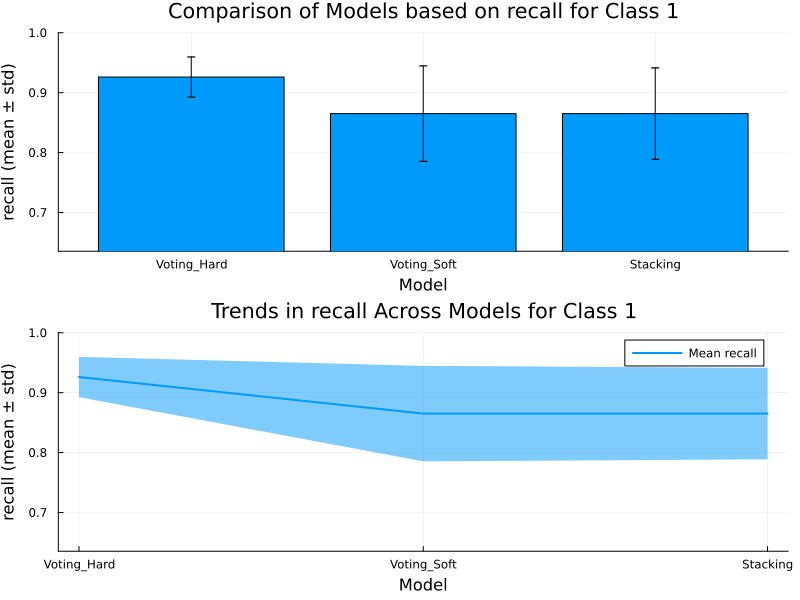

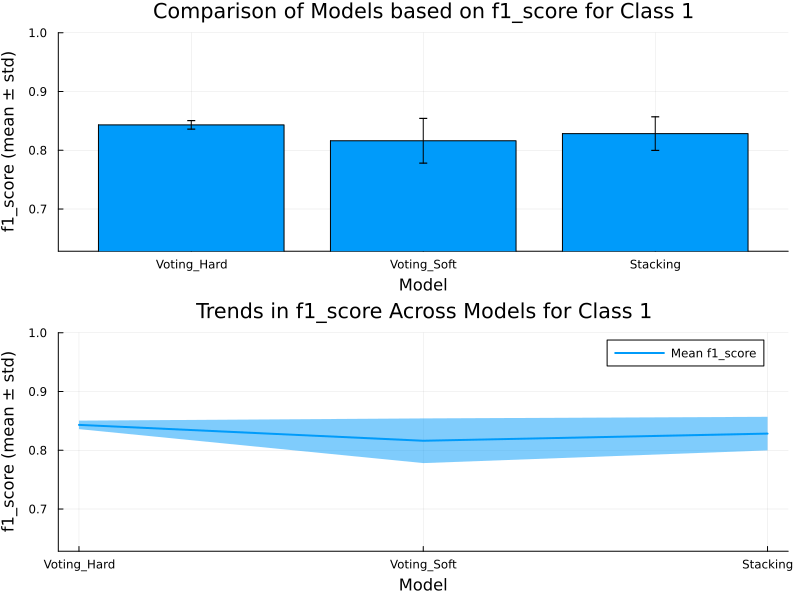

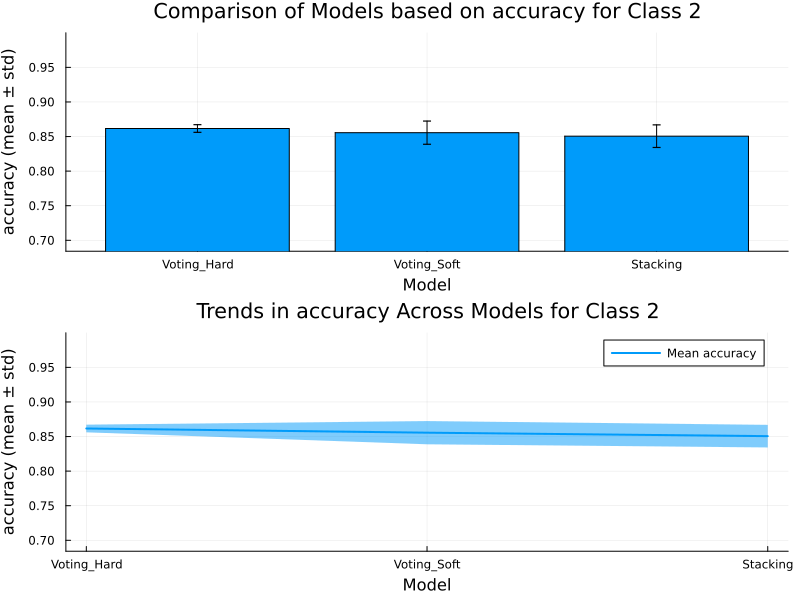

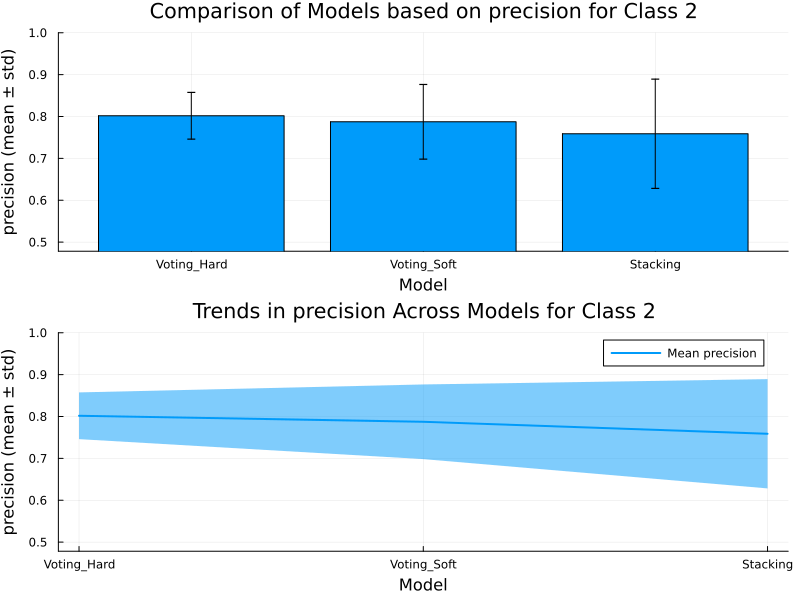

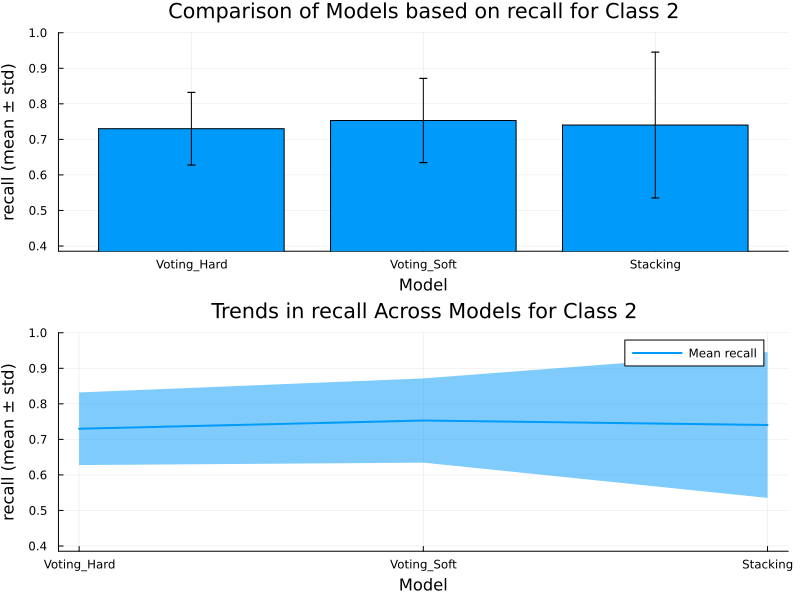

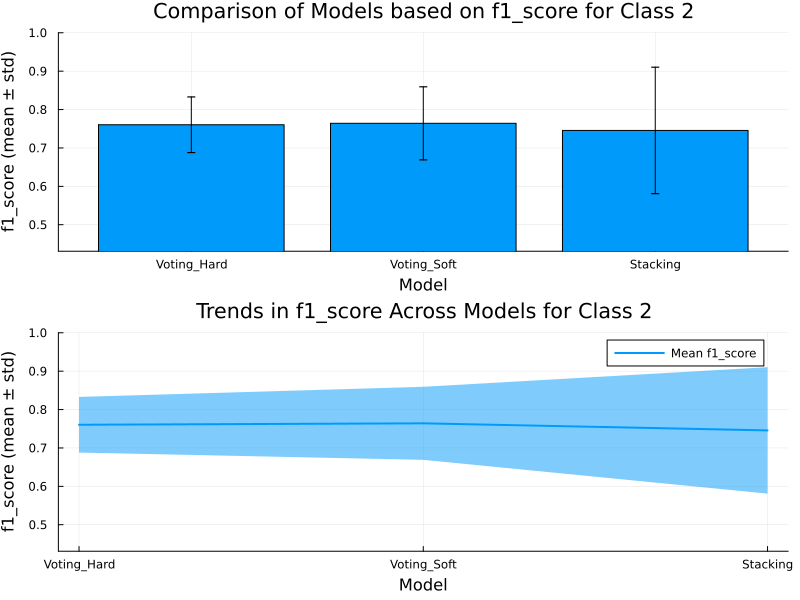

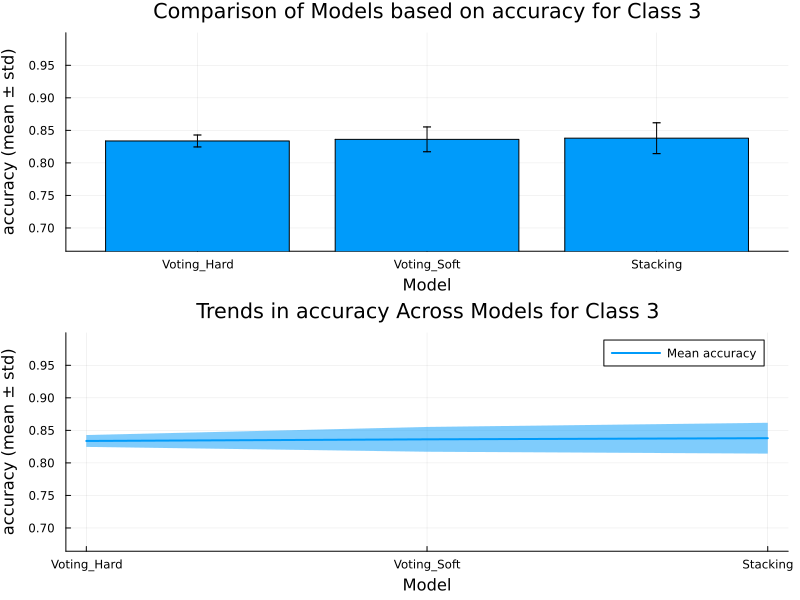

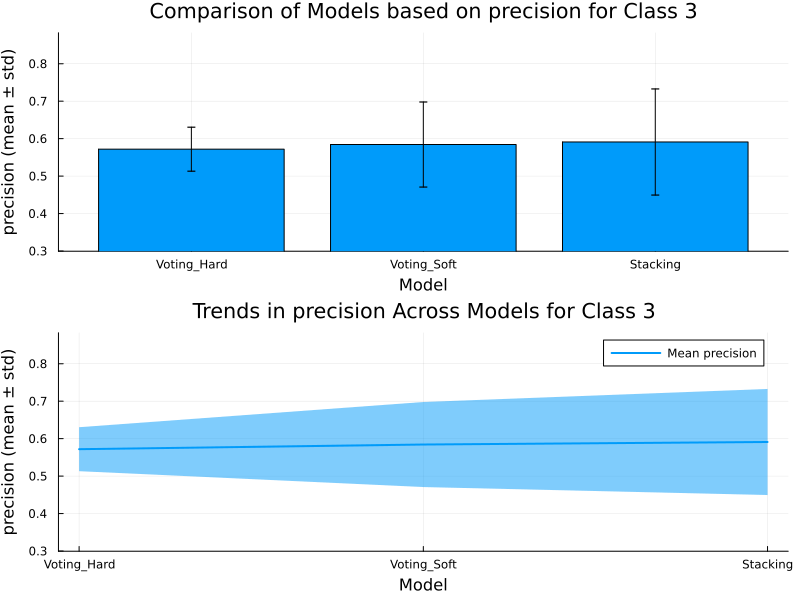

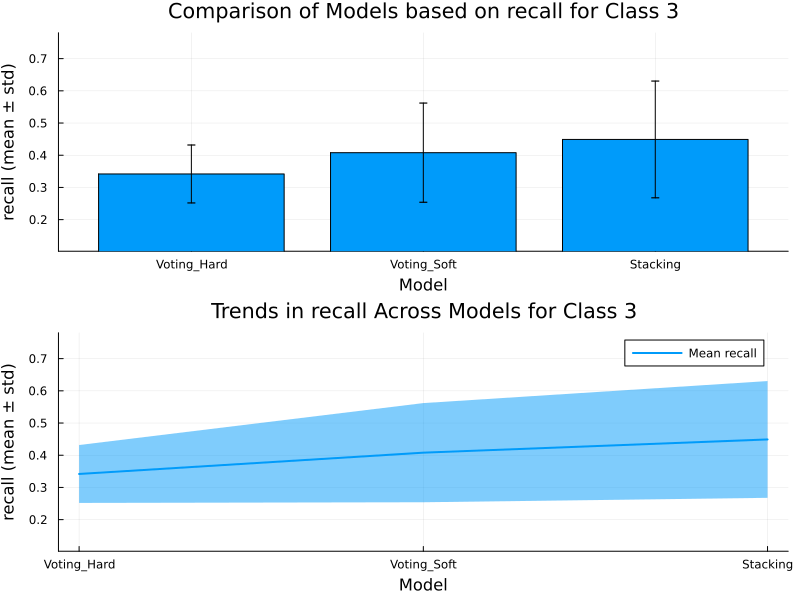

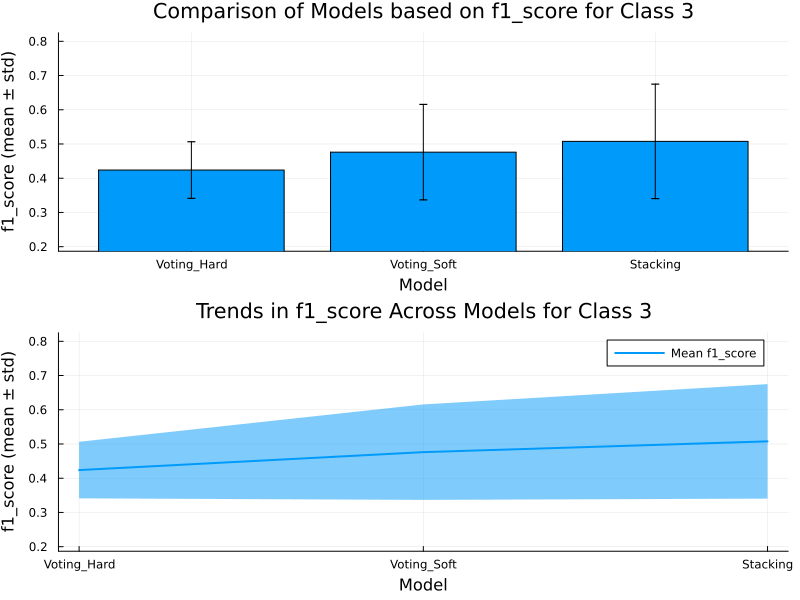

In [58]:
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir=plots_output_dir, show=true)

In [29]:
generateComparisonTable(model_names, metrics, metric_means; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│    Stacking │    0.852 │     0.766 │  0.776 │    0.766 │
│ Voting_Soft │    0.851 │     0.762 │  0.775 │     0.76 │
│ Voting_Hard │    0.848 │     0.759 │  0.772 │    0.756 │
└─────────────┴──────────┴───────────┴────────┴──────────┘


In [30]:
generateComparisonTable(model_names, 3, metrics, metric_means_class; output_dir=tables_output_dir, sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models for Class 1 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Soft │    0.855 │     0.803 │  0.881 │    0.837 │
│    Stacking │    0.857 │     0.811 │  0.861 │    0.832 │
│ Voting_Hard │    0.853 │     0.805 │  0.869 │    0.831 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Models for Class 2 (Sorted by f1_score):
┌─────────────┬──────────┬───────────┬────────┬──────────┐
│       Model │ Accuracy │ Precision │ Recall │ F1-Score │
├─────────────┼──────────┼───────────┼────────┼──────────┤
│ Voting_Hard │    0.854 │     0.789 │   0.77 │     0.77 │
│    Stacking │    0.855 │     0.764 │  0.731 │    0.742 │
│ Voting_Soft │    0.852 │     0.764 │  0.722 │    0.733 │
└─────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Metrics Across Mo

# Evaluation of the best ensemble

The best result was obtained with the Stacking method. So, we train it with the whole training dataset and evaluate it with the test set:

In [ ]:
# Select the best models
estimators = [:ANN, :SVC, :DT]
models_hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (64),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
    :kernel => "linear",
    :C => 10.0,
    :gamma => "auto",
    :probability => true,
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
)])

type = :Stacking
hyperparameters = Dict(
    :final_estimator => LogisticRegression()
)

println("Training ensemble...")
metrics = trainEnsemble(
  estimators,
  models_hyperparameters,
  (inputs, targets),
  (test_inputs, test_targets);
  ensembleType=type,
  ensembleHyperParameters=hyperparameters
);

Training ensemble...


In [13]:
metrics_to_save = [:accuracy, :precision, :recall, :f1_score]
println("Metrics: ")
for metric in metrics_to_save
  println("\t", metric, ": ", round(metrics[metric], digits=5))
end

Metrics: 
	accuracy: 0.86265
	precision: 0.77563
	recall: 0.78614
	f1_score: 0.77856


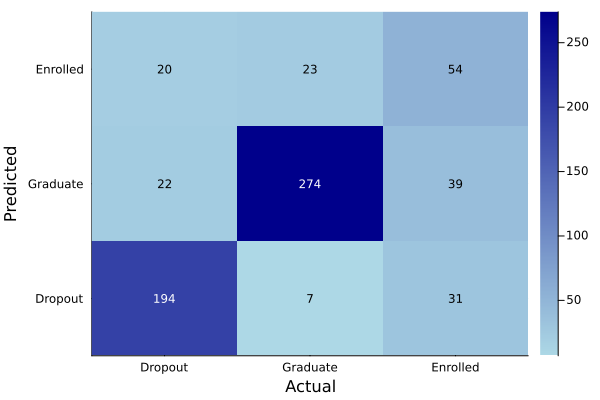

"/Users/eliseopitavilarino/Documents/Documentos/USC/Master/Q1/ML1/Final-Project-MaLea/plots/Approach1/stacking_confusion_matrix.png"

In [14]:
conf_matrix = metrics[:confusion_matrix]
showConfusionMatrix(conf_matrix; output_dir="./plots/Approach1/", filename="stacking_confusion_matrix.png")

We end up obtaining a recall of the $77,85\%$, with both precision and recall obtaining similar results.  If we analuze the classes, the worst performance is obtained with the class "Enrolled", with a recall of $43,55\%$ and precision of $55,67\%$. It seems that the model is having trouble identifying this class.